In [106]:
# general imports
import numpy as np
import pandas as pd

# scipy imports
from scipy.fftpack import fft
from scipy.io import wavfile

# custom classes
%run classes/measure.py
%run classes/note.py

class Music:
    
    def __init__(self, 
                 time_signature=(4, 4),
                 tempo=60,
                 ver_number="0.00"):
            
        self.time_signature = time_signature
        self.tempo = tempo
        self.ver_number = ver_number # version number of decoder

    def read(self, input_path, is_wav_format=True):
        self.input_path = input_path
        if is_wav_format:
            self.sample_rate, self.raw = wavfile.read(input_path)
        self.chan1, self.chan2 = zip(*self.raw)
        
    def compile_music(self, separation=5000, min_volume_level=5000, max_pitch=8000, use_chan1=True):
        self.measures = list()
        
        if use_chan1:
            peaks = self.find_peaks(self.chan1, separation, min_volume_level)
            notes = self.get_notes(self.chan1, peaks, separation, max_pitch)
#         notes = self.filter_notes(notes)
#         for i, note in enumerate(notes):
#             measure = Measure(i+1)
#             measure.addNote(note)
#             self.addMeasure(measure)
        return notes
    
    def get_notes(self, sound, peaks, separation, max_pitch):
        notes = list()
        for peak, loudness in peaks:
            inspection_zone = sound[peak: peak + separation]
            fft_data = np.abs(fft(inspection_zone))

            conversion_factor = self.sample_rate / len(fft_data)
            max_signal = max(fft_data)
            resonant_freqs = (-fft_data[:max_pitch]).argsort()
            timestamp = peak / self.sample_rate

            for freq in resonant_freqs:
                signal = fft_data[freq]
                if signal < max_signal * 0.4:
                    break
                note = Note(freq * conversion_factor, signal, loudness, timestamp)
                notes.append(note.getInfo())
        notes = pd.DataFrame(notes, columns=["time", "id", "signal", "pitch", "given_pitch",
                                             "loudness", "duration", "note", "octave", "alter"])
        return notes

    # ideally this is when dynamics will come in
    def filter_notes(self, notes):
        N = len(notes)
        to_delete = list()
        for i in range(1, N):
            if notes.iloc[i - 1].given_pitch == notes.iloc[i].given_pitch:
                to_delete.append(i)
        for index in list(reversed(to_delete)):
            notes.drop([index])
        return notes
    
    def find_peaks(self, sound, separation, min_volume_level):

        # return value of peak positions and signal strength
        peaks = list()

        # initializing variables
        max_prev_i = np.argmax(sound[:separation])
        max_next_i = np.argmax(sound[separation + 1: 2 * separation]) + separation + 1
        max_prev   = sound[max_prev_i]
        max_next   = sound[max_next_i]

        for i in range(separation, len(sound) - separation - 1):

            # Determining the maximum value in the previous window
            if sound[i - 1] > max_prev:
                max_prev_i = i - 1
                max_prev   = sound[max_prev_i]
            elif i - max_prev_i > separation:
                max_prev_i = np.argmax(sound[i - separation: i - 1]) + i - separation
                max_prev   = sound[max_prev_i]

            # Determining the maximum value in the next window
            if sound[i + separation + 1] > max_next:
                max_next_i = i + separation + 1
                max_next   = sound[max_next_i]
            elif max_next_i == i:
                max_next_i = np.argmax(sound[i + 1: i + separation + 1]) + i + 1
                max_next = sound[max_next_i]

            # Determining if the current point is a peak
            if sound[i] > max_prev and sound[i] > max_next and sound[i] > min_volume_level:
                if len(peaks) == 0 or i - peaks[-1][0] > separation:
                    peaks.append((i, sound[i]))
        return peaks
        
    def addMeasure(self, measure):
        self.measures.append(measure)

In [107]:
music = Music()
music.read('sounds/wav/cello_pluck/multi/a3_d3.wav')

In [108]:
music.compile_music()

,time,id,signal,pitch,given_pitch,loudness,duration,note,octave,alter
0,1.714146,108,2.373859e+07,47788.8,7902.13,22888,4,B,8,0
1,1.714146,45,2.373859e+07,211.2,207.65,22888,4,G,3,1
2,1.714146,108,1.972670e+07,47779.2,7902.13,22888,4,B,8,0
3,1.714146,46,1.972670e+07,220.8,220.00,22888,4,A,3,0
4,1.714146,108,1.011823e+07,47798.4,7902.13,22888,4,B,8,0
5,1.714146,44,1.011823e+07,201.6,196.00,22888,4,G,3,0
6,3.457146,108,1.361921e+07,47856.0,7902.13,10751,4,B,8,0
7,3.457146,39,1.361921e+07,144.0,146.83,10751,4,D,3,0


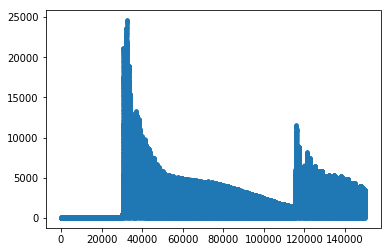

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(music.chan1[50000:200000]), ".")

In [52]:
mx = np.abs(music.chan1).argmax()
mx

82392

In [53]:
np.abs(music.chan1)[mx]

24607

In [77]:
def find_peaks(chan1):
    # variables that can be configured
    separation = 5000
    min_volume_level = 5000
    
    # return value of peak positions and signal strength
    peaks = list()
    
    # initializing variables
    max_prev_i = np.argmax(chan1[:separation])
    max_next_i = np.argmax(chan1[separation + 1: 2 * separation]) + separation + 1
    max_prev   = chan1[max_prev_i]
    max_next   = chan1[max_next_i]
    
    for i in range(separation, len(chan1) - separation - 1):
        
        # Determining the maximum value in the previous window
        if chan1[i - 1] > max_prev:
            max_prev_i = i - 1
            max_prev   = chan1[max_prev_i]
        elif i - max_prev_i > separation:
            max_prev_i = np.argmax(chan1[i - separation: i - 1]) + i - separation
            max_prev   = chan1[max_prev_i]
        
        # Determining the maximum value in the next window
        if chan1[i + separation + 1] > max_next:
            max_next_i = i + separation + 1
            max_next   = chan1[max_next_i]
        elif max_next_i == i:
            max_next_i = np.argmax(chan1[i + 1: i + separation + 1]) + i + 1
            max_next = chan1[max_next_i]
            
        # Determining if the current point is a peak
        if chan1[i] > max_prev and chan1[i] > max_next and chan1[i] > min_volume_level:
            if len(peaks) == 0 or i - peaks[-1] > separation:
                peaks.append(i)
    return peaks

In [78]:
find_peaks(music.chan1)

[82279, 165943]